In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import multiprocessing
from gensim.models import Word2Vec
from tqdm import tqdm
from gensim.utils import RULE_DEFAULT, RULE_KEEP
from gensim.models.callbacks import CallbackAny2Vec

In [2]:
ngram_abstracts = np.load("saved_files/ngram_abstracts.npy", mmap_mode="r")
concept_arr = np.unique(np.load("saved_files/overlapping_concepts.npy"))
year_arr = np.load("saved_files/year_arr.npy", mmap_mode="r")

In [3]:
def compute_word_count_subset(corpus, subset_words):
    
    for document in tqdm(corpus):
        for word in document:
            if word in subset_words:
                subset_words[word] += 1
    return subset_words

# Compute word count for the subset of words 
word_count_subset = compute_word_count_subset([row.split() for row in ngram_abstracts], {k:0 for k in np.unique(concept_arr)})

def filter_dict_by_occurrence(word_count_dict, n):
    return {word: count for word, count in word_count_dict.items() if count > n}

filtered_concept_dict = np.array(list(filter_dict_by_occurrence(word_count_subset, 4).keys()))

100%|██████████| 157821/157821 [00:00<00:00, 215450.78it/s]


In [4]:
df_ab = pd.DataFrame(data=ngram_abstracts,    # values
                columns=["ab"])  # 1st row as the column names
df_ab["year"] = year_arr

In [10]:
# Define important words
phys_concept_dict = {k:1 for k in concept_arr}

# Custom rule function
def custom_rule(word, count, min_count):
    if word in phys_concept_dict:
        return RULE_KEEP
    else:
        return RULE_DEFAULT

cores = multiprocessing.cpu_count()

class LossLogger(CallbackAny2Vec):
    '''Callback to log loss after each epoch.'''
    def __init__(self):
        self.epoch = 0
        self.losses = []
        self.previous_loss = 0
        self.initial_loss = 0

    def on_epoch_begin(self, model):
        # Record the initial loss at the start of each epoch
        self.initial_loss = model.get_latest_training_loss()

    def on_epoch_end(self, model):
        current_loss = model.get_latest_training_loss()
        # Calculate the loss for the current epoch
        loss = current_loss - self.initial_loss
        self.losses.append(loss)
        self.initial_loss = current_loss  # Reset for the next epoch
        self.epoch += 1

loss_logger = LossLogger()

w2v_model = Word2Vec(min_count=5,
                     window=15,
                     vector_size=128,
                     sample=1e-4, 
                     alpha=0.01, 
                     min_alpha= 0.0001, 
                     negative=15,
                     workers=cores-1)


for year in np.unique(year_arr):
    print(f"Processing year: {year}")
    
    ngram_abstracts_year = [ab.split() for ab in df_ab[df_ab['year'] <= int(year)]["ab"].to_numpy()]

    if year == np.unique(year_arr)[0]:
        # Build the vocabulary on the first year's data
        w2v_model.build_vocab(ngram_abstracts_year, trim_rule=custom_rule)
        
    else:
        # Update the vocabulary with the current year's data
        w2v_model.build_vocab(ngram_abstracts_year, update=True, trim_rule=custom_rule)
    
    # Train the model on the current year's data
    w2v_model.train(ngram_abstracts_year, total_examples=w2v_model.corpus_count, epochs=50, compute_loss=True, callbacks=[loss_logger])
    w2v_model.save("saved_models/model_year_{}.model".format(year))

Processing year: 1994
Processing year: 1995
Processing year: 1996
Processing year: 1997
Processing year: 1998
Processing year: 1999
Processing year: 2000
Processing year: 2001
Processing year: 2002
Processing year: 2003
Processing year: 2004
Processing year: 2005
Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
Processing year: 2021
Processing year: 2022
Processing year: 2023
Processing year: 2024


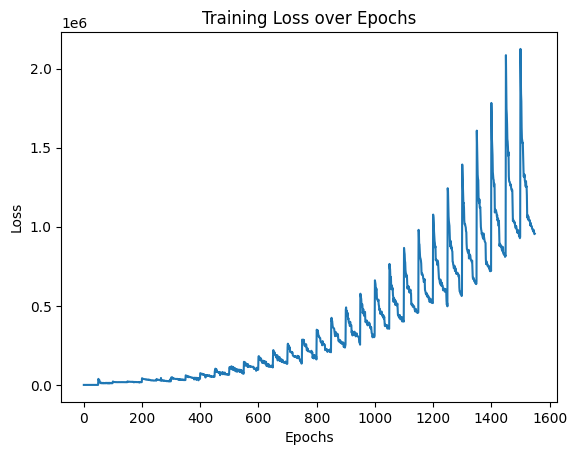

In [14]:
# Plot the training loss
plt.plot(loss_logger.losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [11]:
# c_dict = {}
# cnt_0 = 0 
# cnt_1 = 0
# for year in tqdm(np.unique(year_arr)):
        
#     loaded_w2v = Word2Vec.load("saved_models/model_year_{}.model".format(year))

#     for c in filtered_concept_dict:
#         if c not in c_dict:
#             c_dict[c] = {}

#         if year in c_dict[c]:
#             continue 
#         else:

#             try:
#                 vec_enc = loaded_w2v.wv.get_vector(c)
#                 c_dict[c][year] =  vec_enc
#                 cnt_0 +=1
                
#             except: 
#                 cnt_1+=1
#                 pass
# cnt_1, cnt_0

In [5]:
# import re
# def keep_words_with_underscore(input_string):
#     # Define a regular expression pattern to match words with underscores
#     pattern = r'\b\w*_[\w_]*\b'

#     # Use re.findall to extract words that match the pattern
#     matching_words = re.findall(pattern, input_string)

#     # Join the matching words to form the final string
#     result = ' '.join(matching_words)

#     return result

# ocurr_arr = {}
# for abstract, year in tqdm(zip(ngram_abstracts, year_arr)):
#     temp = keep_words_with_underscore(abstract)
#     if year not in ocurr_arr:
#         ocurr_arr[year] = []
#     if temp.count(" ") > 0:
#         temp = temp.split(" ") 
#         temp = [s for s in temp if s in filtered_concept_dict]
#         l = [list(filter(("_").__ne__, temp))]
#         ocurr_arr[year].extend(l)


In [4]:
# def flatten_matrix(matrix):
#     flat = []
#     for r in matrix:
#         # for c in r:
#         flat += r
#     return np.unique(flat)

# new_ocurr_arr = {}
# for year in tqdm(np.unique(year_arr)):
#     new_ocurr_arr[year] = flatten_matrix(ocurr_arr[year])
    

In [3]:
# # year_arr = df_arx['date'].dt.year.to_numpy()

# years, numpapers_y = np.unique(year_arr,return_counts=True)
# # months, numpapers_m = np.unique(month_arr,return_counts=True)

# fig, ax = plt.subplots(figsize=(3.5,3))
# # fig.set_size_inches(3.54,3.54)

# ax.plot( np.arange(len(numpapers_y))[:-1], numpapers_y[:-1], '-o', markersize=3 )

# ax.set_xticks( list(range(len(years))[::3]))
# ax.set_xticklabels( years[::3], rotation=75 )
# ax.set_yscale("log")
# # ax.grid()

# ax2 = fig.add_axes([0.6, 0.25+0.1, 0.25, 0.25])
# ax2.plot(np.arange(len(numpapers_y))[:-1], cumulative_sum[:-1])

# ax2.set_xticks( list(range(len(years))[::5]))
# ax2.set_xticklabels( years[::5], rotation=75 )
# ax2.set_yscale("log")
# # ax2.legend(fancybox=True, ncol=2, prop={'size':3})
# # ax2.set_yticklabels([])
# # ax2.yaxis.grid(True)

In [2]:
# # Dictionary to store the first occurrence year of each word
# first_occurrences = {}

# # Dictionary to count the number of first occurrences per year
# new_words_per_year = {}

# # Iterate through the years in sorted order
# for year in sorted(new_ocurr_arr.keys()):
#     new_words_count = 0
#     for word in new_ocurr_arr[year]:
#         if word not in first_occurrences:
#             first_occurrences[word] = year
#             new_words_count += 1
#     new_words_per_year[year] = new_words_count

# years = sorted(new_words_per_year.keys())
# cumulative_sum = [sum(new_words_per_year[y] for y in years if y <= year) for year in years]

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(years, cumulative_sum, marker='o', linestyle='-', color='b')
# plt.title('Cumulative Sum of New Concepts Over Years')
# plt.xlabel('Year')
# plt.ylabel('Cumulative Sum of New Concepts')
# plt.grid(True)
# plt.xticks(years)
# plt.tight_layout()
# # plt.yscale("log")
# plt.show()

In [ ]:
# l_arr = []
# for year in year_arr:
#     l_arr .append( len(ocurr_arr[year]))

In [ ]:
# c_dict = {}
# cnt_0 = 0 
# cnt_1 = 0
# for year in tqdm(np.unique(year_arr)):
        
#     loaded_w2v = Word2Vec.load("saved_models/model_year_{}.model".format(year))

#     for c in filtered_concept_dict:
#         if c not in c_dict:
#             c_dict[c] = {}

#         if year in c_dict[c]:
#             continue 
#         else:

#             try:
#                 vec_enc = loaded_w2v.wv.get_vector(c)
#                 c_dict[c][year] =  vec_enc
#                 cnt_0 +=1
                
#             except: 
#                 cnt_1+=1
#                 pass
# cnt_1,cnt_0

In [ ]:
# c_sfdict = sfdict(c_dict, filename='files/concept_year_dict.db') 
# c_sfdict.sync()  # synchronize all changes back to disk
# c_sfdict.close()  # should always close a db

Second pass: Fill in empty entries: 

1994: empty 1995: empty 1996: encoding, then use same value as 1996 

1996: encoding_0 1997: empty 1998: encoding_1 use same value as 1998, i.e. always from right to left 

In [12]:
# len_arr = []
# len_new_arr = []
# concept_inx_arr = []


# for c in tqdm(filtered_concept_dict):
   
#     l = len(c_dict[c])
#     len_arr.append(l)
    
#     if l > 0:
#         concept_inx_arr.append(c)
#         for success_inx, success_year in enumerate(np.unique(year_arr)): 
#             if success_year in c_dict[c]:
#                 break
            
#         for inx, year in enumerate(np.unique(year_arr)[:success_inx]): 
#             if year not in c_dict[c]:
#                 c_dict[c][year] = c_dict[c][success_year]
#             else:
#                 pass

#     len_new_arr.append(len(c_dict[c]))
# concept_inx_arr = np.array(concept_inx_arr)

In [ ]:
# c_dict["ac_stark_shift"].keys()

# def filter_dict_by_keys(input_dict, allowed_keys):
#     # Create a new dictionary to store filtered key-value pairs
#     filtered_dict = {}
    
#     # Iterate over the items in the input dictionary
#     for key, value in input_dict.items():
#         # Check if the current key is in the list of allowed keys
#         if key in allowed_keys:
#             # If yes, add the key-value pair to the filtered dictionary
#             filtered_dict[key] = value
    
#     return filtered_dict

In [13]:
# c_sfdict = sfdict(c_dict, filename='files/concept_year_dict_filled_1.db') 
# c_sfdict.sync()  # synchronize all changes back to disk
# c_sfdict.close()  # should always close a db

In [ ]:
# takes about 60 mins
# for year in tqdm(np.unique(year_arr)):
        
#     c_dict = sfdict(filename='files/concept_year_dict_new.db')    
#     loaded_w2v = Word2Vec.load("saved_models/model_year_{}.model".format(year))

#     for c in concept_arr:
#         if c not in c_dict:
#             c_dict[c] = {}

#         if year in c_dict[c]:
#             continue 
#         else:

#             try:
#                 vec_enc = loaded_w2v.wv.get_vector(c)
#                 c_dict[c][year] =  vec_enc
#             except: 
#                 pass

# # takes about 12 mins
# len_arr = []
# len_new_arr = []
# concept_inx_arr = []

# c_dict = sfdict(filename='files/concept_year_dict_new.db')
# for c in tqdm(concept_arr):
   
#     l = len(c_dict[c])
#     len_arr.append(l)
    
#     if l > 0:
#         concept_inx_arr.append(c)
#         for success_inx, success_year in enumerate(np.unique(year_arr)): 
#             if success_year in c_dict[c]:
#                 break
            
#         for inx, year in enumerate(np.unique(year_arr)[:success_inx]): 
#             if year not in c_dict[c]:
#                 c_dict[c][year] = c_dict[c][success_year]
#             else:
#                 pass

#     len_new_arr.append(len(c_dict[c]))
# concept_inx_arr = np.array(concept_inx_arr)
# c_dict.sync()  # synchronize all changes back to disk
# c_dict.close()  # should always close a db

# # check which concepts worked out

# len_new_arr = []


# c_dict = sfdict(filename='files/concept_year_dict.db')
# for c in tqdm(concept_arr):
   
#     l = len(c_dict[c])
#     if l > 0:
        
#         len_new_arr.append(len(c_dict[c]))
    
# c_dict.close()  # should always close a db

In [1]:

# found = False
# a_arr = []
# while not found:
#     c1=np.random.choice(concept_inx_arr)
#     c2=np.random.choice(concept_inx_arr)

#     zx_d = c_dict[c1]
#     su_d = c_dict[c2]

#     track_vec_bell_inequality = np.array([zx_d[i] for i in np.unique(year_arr)])
#     track_vec_schroding_equation = np.array([su_d[i] for i in np.unique(year_arr)])

#     def similarity_cosine(vec1, vec2):
#         cosine_similarity = np.dot(vec1, vec2)/(np.linalg.norm(vec1)* np.linalg.norm(vec2))
#         return cosine_similarity

#     a = [similarity_cosine(v1, v2) for (v1,v2) in zip(track_vec_bell_inequality,track_vec_schroding_equation)]

#     a_arr .append(a)
#     if (a[-1]-a[0])<0.3:
#         found = True 
        
# plt.plot(np.unique(year_arr),a)
# plt.ylabel("Cosine Sim")
# plt.xlabel("Year")
# plt.title(c1 + " vs "+c2)

In [ ]:
# import heapq


# class TopNegativeValuesTotal:
#     def __init__(self):
#         self.heap = []
#         self.size = 100

#     def add_value(self, value, string1, string2):
#         if len(self.heap) < self.size:
#             heapq.heappush(self.heap, [-value, string1, string2])  # Negate the value to make it comparable for a min heap
#         else:
#             min_val = self.heap[0][0]
#             if -value > min_val:  # Negate the value to compare with the minimum value in the heap
#                 heapq.heapreplace(self.heap, [-value, string1, string2])  # Negate the value to make it comparable for a min heap

#     def get_top_values(self):
#         return sorted([[-x[0], x[1], x[2]] for x in self.heap], key=lambda x: x[0])  # Negate the values back to positive
    
# class TopNegativeValuesRelative:
#     def __init__(self):
#         self.heap = []
#         self.size = 100

#     def add_value(self, value, string1, string2):
#         if len(self.heap) < self.size:
#             heapq.heappush(self.heap, [-value, string1, string2])  # Negate the value to make it comparable for a min heap
#         else:
#             min_val = self.heap[0][0]
#             if -value > min_val:  # Negate the value to compare with the minimum value in the heap
#                 heapq.heapreplace(self.heap, [-value, string1, string2])  # Negate the value to make it comparable for a min heap

#     def get_top_values(self):
#         return sorted([[-x[0], x[1], x[2]] for x in self.heap], key=lambda x: x[0])  # Negate the values back to positive

# # Example usage:
# top_values_tracker = TopNegativeValuesTotal()

# # Assuming some process generates values
# process_values = np.random.uniform(low=-1, high=1, size=(10000, 3))

# for value, string1, string2 in process_values:
#     if value < 0:  # Only consider negative values
#         top_values_tracker.add_value(value, string1, string2)

# top_100_negative_values = top_values_tracker.get_top_values()
# print("Top 100 negative values:", top_100_negative_values)


In [ ]:
# import heapq

# class TopNegativeValues:
#     def __init__(self):
#         self.heap = []

#     def add_value(self, value):
#         if len(self.heap) < 100:
#             heapq.heappush(self.heap, value)
#         else:
#             if value < self.heap[0]:
#                 heapq.heappop(self.heap)
#                 heapq.heappush(self.heap, value)

#     def get_top_negative_values(self):
#         return sorted(self.heap)

# # Example usage:
# top_negatives = TopNegativeValues()
# process_values = np.random.uniform(low=-1,high=1,size=10000)

# for value in process_values:
#     top_negatives.add_value(value)

# print("Top 100 negative values:", top_negatives.get_top_negative_values())


In [ ]:
# import heapq

# class TopPositiveValuesTotal:
#     def __init__(self):
#         self.heap = []
#         self.size = 100

#     def add_value(self, value, string1, string2):
        
#         if len(self.heap) < self.size:
#             heapq.heappush(self.heap, [value, string1, string2])
#         else:
#             min_val = self.heap[0][0]
#             if value > min_val:
#                 heapq.heapreplace(self.heap, [value, string1, string2])

#     def get_top_values(self):
#         return sorted(self.heap, key=lambda x: x[0], reverse=True)
    
# class TopPositiveValuesRelative:
#     def __init__(self):
#         self.heap = []
#         self.size = 100

#     def add_value(self, value, string1, string2):
        
#         if len(self.heap) < self.size:
#             heapq.heappush(self.heap, [value, string1, string2])
#         else:
#             min_val = self.heap[0][0]
#             if value > min_val:
#                 heapq.heapreplace(self.heap, [value, string1, string2])

#     def get_top_values(self):
#         return sorted(self.heap, key=lambda x: x[0], reverse=True)

# # Example usage:
# top_values_tracker_relative_pos = TopPositiveValuesRelative()
# top_values_tracker_total_pos = TopPositiveValuesTotal()
# top_values_tracker_relative_neg = TopNegativeValuesRelative()
# top_values_tracker_total_neg = TopNegativeValuesTotal()


# top_values_tracker_relative_pos.add_value(relative_change, c_1, c_2)
# top_values_tracker_total_pos.add_value(distance_change, c_1, c_2)
# top_values_tracker_relative_neg.add_value(relative_change, c_1, c_2)
# top_values_tracker_total_neg.add_value(distance_change, c_1, c_2)




# # Assuming some process generates values
# process_values = np.random.uniform(low=-1,high=1,size=(10000,3))

# for value, string1, string2 in process_values:
#     top_values_tracker.add_value(value, string1, string2)

# top_100_positive_values = top_values_tracker.get_top_values()
# print("Top 100 positive values:", top_100_positive_values)
